In [1]:
import torch
CUDA = False#torch.cuda.is_available()
print(CUDA)

False


In [2]:
import time
from lifelines.utils import concordance_index 
import sys
from torch import nn
import numpy as np
import pandas as pd
import network
from torch.utils.data import TensorDataset, Dataset
import torch.utils.data.dataloader as dataloader
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler

In [3]:
DATASET_CHOICE = 1
# WHAS = 1
# GBSG = 2
# METABRIC = 3
# SUPPORT = 4

if (DATASET_CHOICE == 1):
    # WHAS
    ds = pd.read_csv('./datasets/whas1638.csv',sep=',')
    train = ds[:1310]
    valid = train[-100:]
    train = train[:-100]
    test = ds[1310:]
    x_train = train[['0','1', '2', '3', '4', '5']].as_matrix()
    x_valid = valid[['0','1', '2', '3', '4', '5']].as_matrix()
    x_test = test[['0','1', '2', '3', '4', '5']].as_matrix() 
elif (DATASET_CHOICE == 2):
    # GBSG
    ds = pd.read_csv('./datasets/gbsg2232.csv',sep=',')
    train = ds[:1546]
    valid = train[-100:]
    train = train[:-100]
    test = ds[1546:]
    x_train = train[['0','1', '2', '3', '4', '5', '6']].as_matrix()
    x_valid = valid[['0','1', '2', '3', '4', '5', '6']].as_matrix()
    x_test = test[['0','1', '2', '3', '4', '5', '6']].as_matrix() 
elif (DATASET_CHOICE == 3):
    # for METABRIC
    ds = pd.read_csv('./datasets/metabric1904.csv',sep=',')
    train = ds[:1523]
    valid = train[-100:]
    train = train[:-100]
    test = ds[1523:]
    x_train = train[['0','1', '2', '3', '4', '5', '6', '7', '8']].as_matrix()
    x_valid = valid[['0','1', '2', '3', '4', '5', '6', '7', '8']].as_matrix()
    x_test = test[['0','1', '2', '3', '4', '5', '6', '7', '8']].as_matrix() 
elif (DATASET_CHOICE == 4):
    # for SUPPORT
    ds = pd.read_csv('./datasets/support8873.csv',sep=',')
    train = ds[:7098]
    valid = train[-100:]
    train = train[:-100]
    test = ds[7098:]
    x_train = train[['0','1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', ]].as_matrix()
    x_valid = valid[['0','1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']].as_matrix()
    x_test = test[['0','1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13']].as_matrix() 

In [4]:
scl = StandardScaler()
x_train = scl.fit_transform(x_train)

e_train = train['fstat']
t_train = train['lenfol']


x_valid = scl.fit_transform(x_valid)

e_valid = valid['fstat']
t_valid = valid['lenfol']


x_test = scl.transform(x_test)

e_test = test['fstat']
t_test = test['lenfol']

x_train = torch.from_numpy(x_train).float()
e_train = torch.from_numpy(e_train.as_matrix()).float()
t_train = torch.from_numpy(t_train.as_matrix())

x_valid = torch.from_numpy(x_valid).float()
e_valid = torch.from_numpy(e_valid.as_matrix()).float()
t_valid = torch.from_numpy(t_valid.as_matrix())


x_test = torch.from_numpy(x_test).float()
e_test = torch.from_numpy(e_test.as_matrix()).float()
t_test = torch.from_numpy(t_test.as_matrix())

In [5]:
x_train.shape

torch.Size([1210, 6])

In [6]:
print(ds.shape)
ds.head()

(1638, 8)


,0,1,2,3,4,5,lenfol,fstat
0,1.0,84.0,0.0,22.44662,1.0,1.0,7.589239,1
1,0.0,36.0,0.0,31.64232,0.0,1.0,1266.000000,0
2,0.0,76.0,0.0,46.48160,0.0,1.0,1453.000000,0
3,0.0,47.0,1.0,27.58821,1.0,0.0,608.000000,0
4,0.0,80.0,0.0,24.12942,1.0,0.0,22.616980,1


In [7]:
if CUDA:
    x_train = x_train.cuda()
    e_train = e_train.cuda()
    t_train = t_train.cuda()
    x_valid = x_valid.cuda()
    e_valid = e_valid.cuda()
    t_valid = t_valid.cuda()
    x_test = x_test.cuda()
    e_test = e_test.cuda()
    e_test = t_test.cuda()

In [8]:
from tqdm import tqdm_notebook as tqdm

In [9]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight.data)
#         m.weight.data.fill_(0)
#         m.bias.data.fill_(1)

def init_weights_for_cox(m):
    if type(m) == nn.Linear:
        m.weight.data.fill_(0)
        m.bias.data.fill_(0)

t_ = t_train.cpu().data.numpy()
        
print("starting risk set computation...")
risk_set = []
for i in tqdm(range(len(t_))):

    risk_set.append([i]+np.where(t_>t_[i])[0].tolist())

t_ = t_valid.cpu().data.numpy()
        
risk_set_valid = []
for i in tqdm(range(len(t_))):

    risk_set_valid.append([i]+np.where(t_>t_[i])[0].tolist())
    
    
t_ = t_test.cpu().data.numpy()

risk_set_test = []
for i in tqdm(range(len(t_test))):

    risk_set_test.append([i]+np.where(t_>t_[i])[0].tolist())

print("risk set computed")

starting risk set computation...



risk set computed


In [252]:
# def elbo(risk, gated_output, E, risk_set, CUDA):
#     lgo_sm = nn.LogSoftmax(dim=1)(gated_output)
#     lnumerator = torch.mul(torch.exp(lgo_sm), risk)
    
#     lnumerator = torch.sum(lnumerator, dim=1)
    
#     expected_risks = risk + lgo_sm
#     expected_risks = torch.logsumexp(expected_risks, dim=1)
#     ldenominator = []
#     for i in range(risk.shape[0]):
#         ldenominator.append(torch.logsumexp(expected_risks[risk_set[i]], dim=0))
        
#     ldenominator = torch.stack(ldenominator, dim=0)
#    # ldenominator = torch.log(ldenominator)
    
#     likelihoods = lnumerator - ldenominator
    
#     E =  np.where(E.cpu().data.numpy()==1)[0]
    

    
# #     neg_likelihood = - torch.sum(likelihoods[E])
#     likelihoods = likelihoods[E]
#     neg_likelihood = - torch.sum(likelihoods)
    
#     return neg_likelihood

In [10]:
def elbo(risk, gated_output, E, risk_set, CUDA):
    go_sm = nn.Softmax(dim=1)(gated_output)
    lnumerator = torch.mul(go_sm, risk)
    
    lnumerator = torch.sum(lnumerator, dim=1)
    
    expected_risks = torch.exp(risk) * go_sm
    expected_risks = torch.sum(expected_risks, dim=1)
    ldenominator = []
    for i in range(risk.shape[0]):
        ldenominator.append(torch.sum(expected_risks[risk_set[i]], dim=0))
        
    ldenominator = torch.stack(ldenominator, dim=0)
    ldenominator = torch.log(ldenominator)
    
    likelihoods = lnumerator - ldenominator
    
    E =  np.where(E.cpu().data.numpy()==1)[0]
    

    
#     neg_likelihood = - torch.sum(likelihoods[E])
    likelihoods = likelihoods[E]
    neg_likelihood = - torch.sum(likelihoods)
    
    return neg_likelihood

In [14]:
#need to change code so that test runs after model is trained
def train(gated_network, betas_network, risk_set, x_train, e_train, t_train, risk_set_valid, x_valid, e_valid, t_valid, CUDA, 
          optimizer, n_epochs,x_test,e_test,t_test,risk_set_test):
    from tqdm import tqdm_notebook as tqdm
    # Initialize Metrics
    c_index_soft = []
    c_index_hard = []
    train_loss = []
    valid_loss = []
    test_loss = []
    test_c_index_soft = []
    test_c_index_hard = []
    diff = 1e-4
    prev_loss_train = 0
    prev_loss_valid = 0
    bad_cnt = 0
    start = time.time()
      
    for epoch in tqdm(range(n_epochs)):
        gated_network.train()
        betas_network.train()
        optimizer.zero_grad()
        
        gated_outputs = gated_network(x_train)
        lsoftmax = nn.LogSoftmax(dim=1)(gated_outputs)
        betas_output = betas_network(x_train)
        
        ci_train_soft,ci_train_hard = get_concordance_index(betas_output, gated_outputs, t_train, e_train)
        c_index_soft.append(ci_train_soft)
        c_index_hard.append(ci_train_hard)
        
#         loss = negative_log_likelihood(gated_outputs, betas_output, e, risk_set, CUDA)
        loss = elbo(betas_output, gated_outputs, e_train, risk_set, CUDA) + (betas_network[0].weight**2).sum()
        loss.backward()
        optimizer.step()

        my_loss = loss.cpu().data.numpy()
        train_loss.append(my_loss)
        if abs(my_loss - prev_loss_train) < diff:
            break
        prev_loss_train = my_loss
        
        
        torch.cuda.empty_cache()          
        
        
        ################################################# Validation #######################################################
        gated_network.eval()
        betas_network.eval()

        gated_outputs_valid = gated_network(x_valid)
        lsoftmax_valid = nn.LogSoftmax(dim=1)(gated_outputs_valid)
        
        betas_output_valid = betas_network(x_valid)
              
#         loss = negative_log_likelihood(gated_outputs, betas_output, e, risk_set, CUDA)
        loss_valid = elbo(betas_output_valid, gated_outputs_valid, e_valid, risk_set_valid, CUDA)
        

        my_loss_valid = loss_valid.cpu().data.numpy()
        valid_loss.append(my_loss_valid)
        if my_loss_valid - prev_loss_valid > diff:
            bad_cnt+=1
            #if bad_cnt>2:
                #break
        #else:
            #bad_cnt=0
        prev_loss_valid = my_loss_valid
        
        torch.cuda.empty_cache()          

        
        ################################################# Test #############################################################
        gated_network.eval()
        betas_network.eval()

        
        gated_outputs_test = gated_network(x_test)
        lsoftmax_test = nn.LogSoftmax(dim=1)(gated_outputs_test)
        
        betas_output_test = betas_network(x_test)
        
        ci_test_soft,ci_test_hard = get_concordance_index(betas_output_test, gated_outputs_test, t_test, e_test)
        test_c_index_soft.append(ci_test_soft)
        test_c_index_hard.append(ci_test_hard)
        
#         loss = negative_log_likelihood(gated_outputs, betas_output, e, risk_set, CUDA)
        loss_test = elbo(betas_output_test, gated_outputs_test, e_test, risk_set_test, CUDA)
        

        my_loss_test = loss_test.cpu().data.numpy()
        test_loss.append(loss_test)
        
        
        torch.cuda.empty_cache()          
        #print('Finished Training with %d iterations in %0.2fs' % (epoch + 1, time.time() - start))
     
        
    metrics = {}
    metrics['train_loss'] = train_loss
    metrics['c-index-soft'] = c_index_soft
    metrics['c-index-hard'] = c_index_hard
    metrics['test_loss'] = test_loss
    metrics['c-index-test-soft'] = test_c_index_soft
    metrics['c-index-test-hard'] = test_c_index_hard
    return metrics


In [12]:
def elbo_batch(risk, gated_output, E, risk_set, CUDA):
    

    go_sm = nn.Softmax(dim=1)(gated_output)
    lnumerator = torch.mul(go_sm[0], risk[0])

#     lnumerator = torch.sum(lnumerator, dim=1)

    expected_risks = torch.exp(risk) * go_sm
    expected_risks = torch.sum(expected_risks, dim=1)

    ldenominator = torch.sum(expected_risks, dim=0)

    ldenominator = torch.log(ldenominator)

    likelihoods = lnumerator - ldenominator


    neg_likelihood = - torch.sum(likelihoods)
    

    
    return neg_likelihood

In [13]:
#need to fix for hard and soft gating
def train_batch(gated_network, betas_network, risk_set, x, e, t, CUDA, optimizer, n_epochs,x_valid,e_valid,t_valid,risk_set_validation):
    from tqdm import tqdm_notebook as tqdm
    # Initialize Metrics
    c_index = []
    train_loss = []
    valid_loss = []
    
    valid_c_index = []
    diff = 1e-4
    
    prev_loss_train = 0
    prev_loss_valid = 0
    
    start = time.time()
    for epoch in tqdm(range(n_epochs)):
        
        eloss = 0
        
        for i in range(x.shape[0]):
            
            
            if e[i] == 0:
                
                continue
            
            optimizer.zero_grad()
            # print("x: ", x)
            gated_outputs = gated_network(x[risk_set[i]])
            lsoftmax = nn.LogSoftmax(dim=1)(gated_outputs)

            betas_output = betas_network(x[risk_set[i]])
            

    #         loss = negative_log_likelihood(gated_outputs, betas_output, e, risk_set, CUDA)
            loss = elbo_batch(betas_output, gated_outputs, e[i], risk_set, CUDA)
                        
            loss.backward()
            optimizer.step()
            
            
            torch.cuda.empty_cache() 
            
            eloss+=loss.cpu().data.numpy()

        gated_outputs = gated_network(x)
        lsoftmax = nn.LogSoftmax(dim=1)(gated_outputs)
        
        betas_output = betas_network(x)
        
        loss_train = elbo(betas_output, gated_outputs, e, risk_set, CUDA)

        
        ci_train = get_concordance_index(betas_output, gated_outputs, t, e)
        c_index.append(ci_train)
    
            #print('Finished Training with %d iterations in %0.2fs' % (epoch + 1, time.time() - start))

        gated_outputs_valid = gated_network(x_valid)
        lsoftmax_valid = nn.LogSoftmax(dim=1)(gated_outputs_valid)

        betas_output_valid = betas_network(x_valid)

        ci_valid = get_concordance_index(betas_output_valid, gated_outputs_valid, t_valid, e_valid)
        valid_c_index.append(ci_valid)

#         loss = negative_log_likelihood(gated_outputs, betas_output, e, risk_set, CUDA)
        loss_valid = elbo(betas_output_valid, gated_outputs_valid, e_valid, risk_set_validation, CUDA)


        my_loss_valid = loss_valid.cpu().data.numpy()
        valid_loss.append(my_loss_valid)


        torch.cuda.empty_cache()          
            #print('Finished Training with %d iterations in %0.2fs' % (epoch + 1, time.time() - start))
        
        train_loss.append(eloss)
        if abs(eloss - prev_loss) < diff:
            break
        prev_loss = eloss


    metrics = {}
    metrics['train_loss'] = train_loss
    metrics['c-index'] = c_index
    metrics['valid_loss'] = valid_loss
    metrics['c-index-valid'] = valid_c_index
    return metrics


In [14]:
def negative_log_likelihood(risk, lsoftmax, E, risk_set, CUDA):
    
    import numpy as np
    
#     new_risk = []
#     for i in range(len(risk_set)):
#         new_risk.append(risk[risk_set[i]])
        
#     log_risk = []
#     for i in range(len(new_risk)):
#         temp = torch.logsumexp(new_risk[i], 0)
#         log_risk.append(temp)

    lnumerator = risk
    
    idxs = range(risk.shape[0])
    
    
    ldenominator = []
    
    for i in range(len(idxs)):
        ldenominator.append(torch.logsumexp(risk[risk_set[i]], dim=0))
            
                            
    ldenominator = torch.stack(ldenominator, dim=0)
    print(ldenominator.shape)
#     print(lnumerator.shape)
    
    
    likelihoods = lnumerator - ldenominator
    print(likelihoods.shape)
    
    E =  np.where(E.cpu().data.numpy()==1)[0]
    

    
#     neg_likelihood = - torch.sum(likelihoods[E])
    likelihoods = likelihoods[E] + lsoftmax[E]
    likelihoods = torch.logsumexp(likelihoods, dim=1)
    neg_likelihood = - torch.sum(likelihoods)

    return neg_likelihood


In [12]:
def get_concordance_index(x, gated_x, t, e, **kwargs):
#     x = x.detach().cpu().numpy()
    t = t.detach().cpu().numpy()
    e = e.detach().cpu().numpy()
    softmax = torch.nn.Softmax(dim=1)(gated_x)
    
    r = x.shape[0]
    
    soft_computed_hazard = torch.exp(x)
    hard_computed_hazard = soft_computed_hazard[range(r),gated_x.argmax(1)[1]]

    
    soft_computed_hazard = torch.mul(softmax, soft_computed_hazard)
    soft_computed_hazard = torch.sum(soft_computed_hazard, dim = 1)
    
    
    return concordance_index(t,-1*soft_computed_hazard.detach().cpu().numpy(),e),concordance_index(t,-1*hard_computed_hazard.detach().cpu().numpy(),e)


In [15]:
n_in = x_train.shape[1]
k = 5

betas_network = nn.Sequential(nn.Linear(n_in, k, bias=False) )
#betas_network.apply(init_weights)

# Construct Neural Network
layers_sizes = [n_in, k]
layers = []
for i in range(len(layers_sizes)-2):
    layers.append(nn.Linear(layers_sizes[i],layers_sizes[i+1], ))
    layers.append(nn.ReLU())

layers.append(nn.Linear(layers_sizes[-2], layers_sizes[-1], bias=False))
gated_network = nn.Sequential(*layers)
#gated_network.apply(init_weights)

#optimizer = optimizer = torch.optim.SGD(my_network.parameters(), lr=learning_rate, momentum=momentum, weight_decay=L2_reg, nesterov=True)
optimizer = torch.optim.Adam(list(gated_network.parameters()) + list(betas_network.parameters()), lr=1e-3)
betas_network.train()
gated_network.train()

if CUDA:
    gated_network.cuda()
    betas_network.cuda()

# If you have validation data, you can add it as the valid_dataloader parameter to the function
n_epochs = 1000
metrics = train(gated_network, betas_network, risk_set, x_train, e_train, t_train,  risk_set_valid, x_valid, e_valid, t_valid, CUDA, optimizer, n_epochs,x_test,e_test,t_test,risk_set_test)
print() 
print("Done")


Done


In [16]:
print(metrics['c-index-soft'][-1])
print(metrics['c-index-hard'][-1])
print(metrics['c-index-test-soft'][-1])
print(metrics['c-index-test-hard'][-1])

0.8367793509092919
0.8013679285828309
0.8256092217466042
0.8070713539384543


In [17]:
#grid search:

linear_models=[2,5,7,10]
learning_rates=[1e-4,1e-3]
best_k_hard=0
best_lr_hard=0
best_k_soft=0
best_lr_soft=0

best_ci_soft=0
best_ci_hard=0

for k in linear_models:
    for lr in learning_rates:
        n_in = x_train.shape[1]
        betas_network = nn.Sequential(nn.Linear(n_in, k, bias=False) )
        betas_network.apply(init_weights)

    # Construct Neural Network
        layers_sizes = [n_in,20,20, k]
        layers = []
        for i in range(len(layers_sizes)-2):
            layers.append(nn.Linear(layers_sizes[i],layers_sizes[i+1], ))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(layers_sizes[-2], layers_sizes[-1], bias=False))
        gated_network = nn.Sequential(*layers)
        gated_network.apply(init_weights)

    #optimizer = optimizer = torch.optim.SGD(my_network.parameters(), lr=learning_rate, momentum=momentum, weight_decay=L2_reg, nesterov=True)
        optimizer = torch.optim.Adam(list(gated_network.parameters()) + list(betas_network.parameters()), lr=lr)
    
        if CUDA:
            gated_network.cuda()
            betas_network.cuda()

    # If you have validation data, you can add it as the valid_dataloader parameter to the function
        n_epochs = 1000
        metrics = train(gated_network, betas_network, risk_set, x_train, e_train, t_train,  risk_set_valid, x_valid, e_valid, t_valid, CUDA, optimizer, n_epochs,x_test,e_test,t_test,risk_set_test)
        print() 
        print("Models:",k)
        print("Learning Rate:",lr)
    
        print(metrics['c-index-soft'][-1])
        print(metrics['c-index-hard'][-1])
        print(metrics['c-index-test-soft'][-1])
        print(metrics['c-index-test-hard'][-1])
    
        if metrics['c-index-test-soft'][-1]>best_ci_soft:
            best_ci_soft=metrics['c-index-test-soft'][-1]
            best_k_soft=k
            best_lr_soft=lr

        if metrics['c-index-test-hard'][-1]>best_ci_hard:
            best_ci_hard=metrics['c-index-test-hard'][-1]
            best_k_hard=k
            best_lr_hard=lr
        
print('Best Concordance for hard gating:',best_ci_hard, "with parameters:" )
print('Learning rate-',best_lr_hard)
print('Linear models-',best_k_hard)

print('Best Concordance for hard gating:',best_ci_soft, "with parameters:" )
print('Learning rate-',best_lr_soft)
print('Linear models-',best_k_soft)



Models: 2
Learning Rate: 0.0001
0.7459115635399143
0.6869138106757371
0.6102711693359996
0.5792857276346035




Models: 2
Learning Rate: 0.001
0.8218868573252944
0.8218721220084237
0.6411071034779195
0.6411257919228541




Models: 5
Learning Rate: 0.0001
0.8125962400383119
0.7965003622432064
0.6391821936496664
0.6341550019622867




Models: 5
Learning Rate: 0.001
0.835163377825804
0.8182791605781156
0.6565250705488797
0.6154478685828553




Models: 7
Learning Rate: 0.0001
0.7932266660117637
0.7845868585532375
0.6277261769048198
0.6313891121119811



Models: 7
Learning Rate: 0.001
0.8302172231295357
0.7970283777644068
0.6460221644956923
0.6318002579005401



Models: 10
Learning Rate: 0.0001
0.8015226494099733
0.7929589744219459
0.6373507260460857
0.6374254798258236



Models: 10
Learning Rate: 0.001
0.8350233923155322
0.7991551751660793
0.6519837784297968
0.6341923788521557
Best Concordance for hard gating: 0.6411257919228541 with parameters:
Learning rate- 0.001
Linear models- 2
Best Concordance for hard gating: 0.6565250705488797 with parameters:
Learning rate- 0.001
Linear models- 5


In [27]:
print(np.max(metrics['c-index-valid-soft']))
print(np.max(metrics['c-index-valid-hard']))


0.7847247969260844
0.5149482624962082


num of epochs:  1000


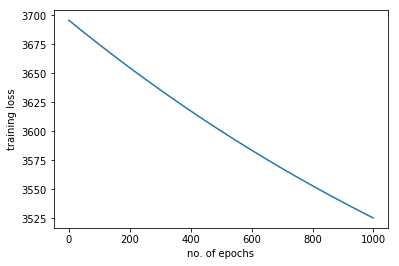

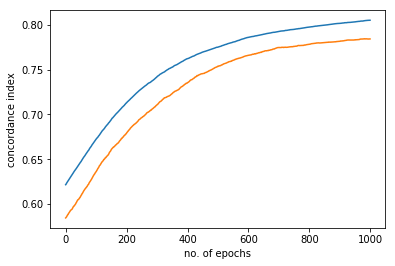

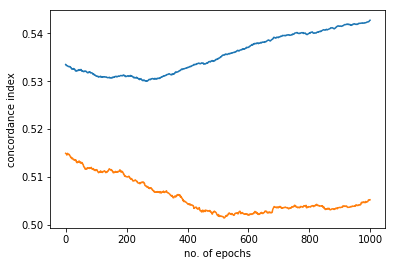

In [29]:
# Print the final metrics
# print('Train C-Index:', metrics['c-index'])
# print('Valid C-Index: ',metrics['valid_c-index'][-1])

print("num of epochs: ", len(metrics['train_loss']))
# print(metrics['train_loss'])
# Plot the training / validation curves
plt.plot(range(len(metrics['train_loss'])), metrics['train_loss'])
plt.xlabel('no. of epochs')
plt.ylabel('training loss')
plt.show()

plt.plot(range(len(metrics['c-index-soft'])), metrics['c-index-soft'])
plt.plot(range(len(metrics['c-index-valid-soft'])), metrics['c-index-valid-soft'])

plt.xlabel('no. of epochs')
plt.ylabel('concordance index')
# plt.plot(range(len(metrics['c-index'])), metrics['c-index'])
plt.xscale('linear')
plt.show()


plt.plot(range(len(metrics['c-index-hard'])), metrics['c-index-hard'])
plt.plot(range(len(metrics['c-index-valid-hard'])), metrics['c-index-valid-hard'])

plt.xlabel('no. of epochs')
plt.ylabel('concordance index')
# plt.plot(range(len(metrics['c-index'])), metrics['c-index'])
plt.xscale('linear')
plt.show()

In [357]:
from lifelines import CoxPHFitter


In [358]:
ds

,0,1,2,3,4,5,lenfol,fstat
0,1.0,84.0,0.0,22.44662,1.0,1.0,7.589239,1
1,0.0,36.0,0.0,31.64232,0.0,1.0,1266.000000,0
2,0.0,76.0,0.0,46.48160,0.0,1.0,1453.000000,0
3,0.0,47.0,1.0,27.58821,1.0,0.0,608.000000,0
4,0.0,80.0,0.0,24.12942,1.0,0.0,22.616980,1
5,0.0,77.0,0.0,23.67519,0.0,0.0,1313.000000,0
6,0.0,90.0,1.0,27.46412,1.0,0.0,1.423138,1
7,0.0,80.0,1.0,29.26457,1.0,0.0,1567.236000,1
8,0.0,40.0,0.0,25.46070,0.0,0.0,1349.000000,0
9,0.0,54.0,1.0,24.41255,1.0,1.0,278.901600,1


In [56]:
CoxPHFitter().fit(ds.iloc[], 'lenfol', 'fstat')

/home/cnagpal/anaconda2/lib/python2.7/site-packages/lifelines/utils/__init__.py:900: ConvergenceWarning: Column 0 have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:
>>> events = df['fstat'].astype(bool)
>>> df.loc[events, '0'].var()
>>> df.loc[~events, '0'].var()

Too low variance here means that the column 0 completely determines whether a subject dies or not.
See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression 
  warnings.warn(warning_text, ConvergenceWarning)


<lifelines.CoxPHFitter: fitted with 1638 observations, 948 censored>

In [60]:
events = ds['fstat'].astype(bool)
ds.loc[events, '0'].var()
ds.loc[~events, '0'].var()



0.0